# Demo Code

This notebook serves as a demo notebook to run the code on a sample of the data since the actual version take several hours to run.
Please go through the actual notebooks to read the notes written along with the code.

Required folder structure to run this code:

~/data/<br>
&nbsp;&nbsp;&nbsp;&nbsp;\-newsqa-data-v1.csv<br>
&nbsp;&nbsp;&nbsp;&nbsp;\-news_stories.pkl

~\newsqa.py<br>
~\utils.py<br>
~\"Demo Code.ipynb"<br>

Please keep the above folder structure, pickle files tend to be sensitive to folder structure.

**Do not run this on a local computer. The BERT model takes nearly 25 minutes to run a single epoch running on a NVIDIA Tesla K80**

In [1]:
# Required imports
import warnings
warnings.filterwarnings("ignore")

import random
import re
import utils
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn.feature_extraction.text import CountVectorizer
from newsqa import NewsQaExample, NewsQaModel, create_dataset, get_single_prediction

from transformers import BertTokenizer, BertForQuestionAnswering
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)


from sklearn.metrics.pairwise import cosine_similarity
import spacy

from spacy.lang.en import English
import en_core_web_md
nlp = en_core_web_md.load()
en = English()

## EDA

In [2]:
# Reading in the dataset
data = pd.read_csv('data/newsqa-data-v1.csv')

# Getting a sample from the dataset
data = data.sample(frac = 0.01, random_state = 9)
data = data.reset_index(drop = True)

data.head()

,story_id,question,answer_char_ranges,is_answer_absent,is_question_bad,validated_answers
0,./cnn/stories/43a488c2d73b4f34122fc92c8df04670...,When was the plane crash?,"2794:2805,372:382|398:410|372:382",0.0,0.0,"{""none"": 2}"
1,./cnn/stories/91607b09ab00b8dff5d7b98387ed132a...,Where has Musharraf lived in exile?,1018:1035|1008:1035|1018:1035,0.0,0.0,NaN
2,./cnn/stories/c674fdceb339915df2a9de1a0bd3007c...,What is he leaving?,529:543|None|237:252,0.0,0.333333333333,"{""237:252"": 2}"
3,./cnn/stories/a0c2d26c2ebecd53dcecc9ea04ae8c5a...,What should the president understand?,None|4317:4469,0.5,0.5,"{""4317:4469"": 2}"
4,./cnn/stories/ad2af6c1362a3f84000edd71fd752ad6...,Bush commutes whose sentence?,"103:129,366:380,384:397,92:103|None",0.0,0.5,"{""103:129"": 2, ""366:380"": 1}"


In [3]:
# Size of the dataset
len(data)

1196

In [4]:
# Convert to numeric and remove non-numeric rows
data = data[pd.to_numeric(data['is_question_bad'], errors = 'coerce').notnull()]
data['is_question_bad'] = data['is_question_bad'].astype(float)

# Number of bad questions
len(data[data['is_question_bad'] > 0])

198

In [5]:
# Remove all bad questions/questions that don't make any sense
data = data[data['is_question_bad'] == 0]
data = data.reset_index(drop = True)

In [6]:
# Final data size
len(data)

868

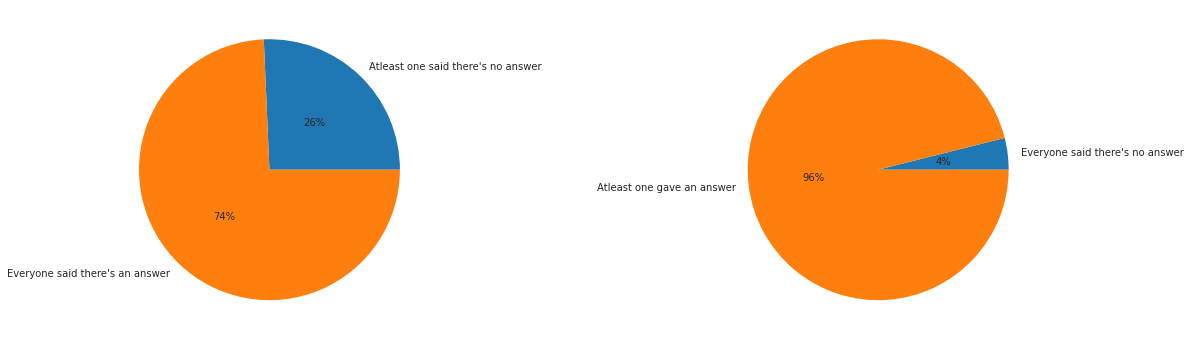

In [7]:
# Answer statistics
fig, ax = plt.subplots(ncols = 2, figsize = (20, 6))

atleast_one_no_ans = len(data[data['is_answer_absent'] != 0])
sizes1 = [atleast_one_no_ans, len(data) - atleast_one_no_ans]
labels1 = ['Atleast one said there\'s no answer', 'Everyone said there\'s an answer']
ax[0].pie(sizes1, labels = labels1, autopct = '%1.0f%%', pctdistance = 0.5, labeldistance = 1.1)

all_no_ans = len(data[data['is_answer_absent'] == 1])
sizes2 = [all_no_ans, len(data) - all_no_ans]
labels2 = ['Everyone said there\'s no answer', 'Atleast one gave an answer']
ax[1].pie(sizes2, labels = labels2, autopct = '%1.0f%%', pctdistance = 0.5, labeldistance = 1.1)

plt.show()

In [8]:
# Precentage of questions that have validated answers
100*data['validated_answers'].isnull().sum()/len(data)

51.84331797235023

In [9]:
# Word counts in questions
cv = CountVectorizer(stop_words = ['the', 'is', 'was', 'of', 'to', 'in'])
dtm = cv.fit_transform(data['question']).toarray()

word_counts = dtm.sum(axis = 0)

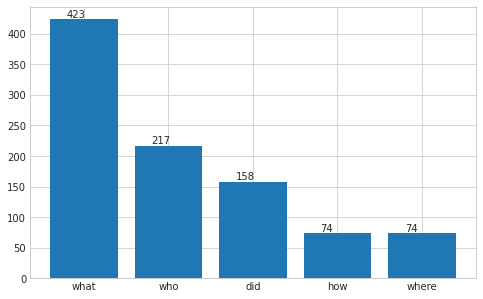

In [10]:
# Plotting top 5 words
fig, ax = plt.subplots(figsize = (8, 5))

sorted_idx = np.argsort(word_counts)[::-1]
vocab = np.array(cv.get_feature_names())

top_words_idx = sorted_idx[:5]
plt.bar(x = vocab[top_words_idx], height = word_counts[top_words_idx])

for i in range(len(top_words_idx)):
    plt.text(x = i - 0.2, y = word_counts[top_words_idx[i]] + 3, s = word_counts[top_words_idx[i]])

plt.show()

In [11]:
# Removing the path and keeping just the file name in story_id
data['story_id'] = data['story_id'].apply(lambda x: x.split('/')[-1].split('.')[0])

## Data Cleaning

In [12]:
# We don't need is_answer_absent and is_question_bad columns
data = data.drop(['is_answer_absent', 'is_question_bad'], axis = 1)

In [13]:
# Reading stories
NEWS_STORIES = utils.open_pickle('data/news_stories.pkl')

In [14]:
def adjust_answer_range(story_id, answer_range):
    '''
    Checks if answer range starts or ends in the middle of a words
    and returns the correct answer range along with answer text
    
    Parameters
    ------------
    story_id: str
              The story id where the answer is present
    
    answer_range: str
                  The answer range to check
                  
    Returns
    -----------
    [start_idx, end_idx]
    '''
    # If answer is not available, denote it as -1
    if answer_range == 'None':
        return [-1, -1]
    
    story = NEWS_STORIES[story_id]
    
    # Check for errors in answer
    if len(answer_range.split(':')) == 1:
        return [-1, -1]
    
    start_idx, end_idx = answer_range.split(':')
    start_idx, end_idx = int(start_idx), int(end_idx)
    
    # Moves back start_idx to the start of a word
    while start_idx != 0 and not utils.is_whitespace(story[start_idx - 1]) and not utils.is_punct(story[start_idx - 1]):
        start_idx = start_idx - 1
    
    # Some ranges end with a punctuation or a whitespace
    if utils.is_whitespace(story[end_idx - 1]) or utils.is_punct(story[end_idx - 1]):
        end_idx = end_idx - 1
    
    # Moves end_idx to the end of a word
    while not utils.is_whitespace(story[end_idx]) and not utils.is_punct(story[end_idx + 1]):
        end_idx = end_idx + 1
        
    # There are some answers with \n at the end followed by a letter
    # The answer will not be in two different paragraphs
    answer_text = story[start_idx:end_idx]
    answer_para = re.split('\n', answer_text)
    
    if len(answer_para[-1]) > len(answer_para[0]):
        start_idx = end_idx - len(answer_para[-1])
        answer_text = answer_para[-1]
    else:
        end_idx = start_idx + len(answer_para[0])
        answer_text = answer_para[0]
    
    return [start_idx, end_idx]

In [15]:
def get_answer(qa_details):
    '''
    A function that selects an answer for a question
    
    > If validated answers are available, the one with most votes is selected
    > If there's a tie in validated answer votes or if validated answer is not
      available, the most frequent answer is selected
    > If there's a tie here too, a random answer is selected
    
    Parameters
    ------------
    qa_details: Pandas Series
                Details of a QA pair, must include story_id, question, 
                answer_char_ranges, validated_answers as index
    '''
    # If validated answers are available, select the one with most votes
    if qa_details['validated_answers'] is not np.nan:
        validated_answers = eval(qa_details['validated_answers'])
        
        # Get the answers with maximum votes
        max_vote_ans = utils.get_max_keys(validated_answers)
        
        # Check for ties
        if len(max_vote_ans) == 1:
            return adjust_answer_range(qa_details['story_id'], max_vote_ans[0])
    
    # If validated answers are not available or if there is a tie in validated answers
    # Get all available answers
    answers = re.split(',|\|', qa_details['answer_char_ranges'])
    
    # If there is just one answer
    if len(answers) == 1:
        return adjust_answer_range(qa_details['story_id'], answers[0])
    
    # Get counts of each answer
    answer_freq = utils.get_frequency(answers)
    max_vote_ans = utils.get_max_keys(answer_freq)
    
    if len(max_vote_ans) == 1:
        return adjust_answer_range(qa_details['story_id'], max_vote_ans[0])
    
    # If there is a tie for multiple answers, return a random answer
    return adjust_answer_range(qa_details['story_id'], random.choice(answers))

In [16]:
# Select one answer range among multiple answers
data[['start_idx', 'end_idx']] = data.apply(get_answer, axis = 1, result_type = 'expand')

In [17]:
data.sample(n = 5)

,story_id,question,answer_char_ranges,validated_answers,start_idx,end_idx
511,515155cfbf26b42b9d66ec2ada5c1f0d598352e3,What are investigators trying to determine?,1864:1882|1864:1882,NaN,1862,1881
483,37686673ec29899e6c8fe88639aa52f0ae062f1c,Who have popularized the fist bump?,"502:528|577:579,5920:5944,5948:5979,5993:6037|...",NaN,500,535
759,bc424cbf48b978f1a64fdd40ecff81dac48d37f8,What was Obama expected to do?,"63:98|3001:3016,3019:3059|3001:3016,3019:3059",NaN,3001,3020
194,9b46d8524c55d9f5c6db59228777bf52d6469fc4,Who lived in the home?,110:138|110:138,NaN,110,137
830,9646c774f004b21fd056d86ea35b5aa3e7531f87,What areas of the world were affected?,"2418:2444,2448:2455|None|0:8,321:330,333:351,8:16","{""333:351"": 1, ""0:8"": 1, ""8:16"": 1}",8,15


## Baseline Model

In [18]:
# Total examples in the dataset
total_examples = len(data)

In [19]:
def simple_tokenizer(doc, model=en):
    # a simple tokenizer for individual documents
    parsed = model(doc)
    return([t.lower_ for t in parsed if (t.is_alpha)&(not t.like_url)])

In [20]:
def get_doc_embedding(tokens, model = nlp):
    '''
    Returns the embedding of a document by averaging the
    GloVe embeddings of all tokens in the document
    
    Parameters
    -----------
    tokens: list
            The list of document tokens
    
    model: The model to use for getting embeddings
    '''
    embeddings = []
    for t in tokens:
        embeddings.append(model.vocab[t].vector)
    
    embeddings = np.array(embeddings)
    if embeddings.ndim == 1:
        return embeddings
    else:
        return np.mean(embeddings, axis = 0)

In [21]:
def predict_answer(text, question):
    '''
    Returns the start and end indices of the sentence that
    has the maximum cosine similarity with the question
    
    Parameters
    -----------
    text: str
          The text to find the answer in
    
    question: str
              The question to answer
    '''
    # Stores the start position of each sentence
    sentence_to_char_idx = [0]
    
    sentences = []
    start_idx = 0
    
    for idx, char in enumerate(text):
        # If the chracter is a punctuation, we append the sentence
        if utils.is_punct(char):
            sentences.append(text[start_idx:idx])
            start_idx = idx + 1
            sentence_to_char_idx.append(start_idx)
    
    # Getting embeddings for each sentence
    sentence_embeddings = []
    for s in sentences:
        tokens = simple_tokenizer(s)
        embd = get_doc_embedding(tokens)
        if embd.shape == (300,):
            sentence_embeddings.append(embd)
    
    sentence_embeddings = np.stack(sentence_embeddings)
    
    # Getting the embedding for the question
    question_embedding = get_doc_embedding(simple_tokenizer(question))
    question_embedding = np.expand_dims(question_embedding, axis = 0)
    
    #print(sentence_embeddings.shape)
    # Get the cosine similarity of each sentence with the question
    similarity = cosine_similarity(sentence_embeddings, question_embedding)
    
    # Get the sentence with the most similarity
    best_idx = np.argmax(similarity)
    
    # Get the sentence start and end index
    pred_start = sentence_to_char_idx[best_idx]
    pred_end = sentence_to_char_idx[best_idx + 1] - 1
    
    return pred_start, pred_end

In [22]:
def calculate_metrics(pred_start, pred_end, true_start, true_end):
    '''
    Calculates the f1 score and if the predicted answer overlaps 
    with the correct one

    Parameters
    -----------
    pred_start, pred_end: int
                          The predicted start and end indices

    true_start, true_end: int
                          The actual indices
    '''
    # Get the overlap
    overlap = set(range(true_start, true_end)).intersection(range(pred_start, pred_end))
    overlap = len(overlap)

    # If either of them have no answer
    if true_end == 0 or pred_end == 0:
        f1_score = int(true_end == pred_end)
        is_correct = int(end_idx == pred_end)
        return f1_score, is_correct
    
    # If they don't overlap at all
    if overlap == 0 or pred_start >= pred_end:
        f1_score = 0
        is_correct = 0
        return f1_score, is_correct

    # If there is an overlap, we consider it correct
    is_correct = 1

    precision = overlap / (pred_end - pred_start)
    recall = overlap / (true_end - true_start)
    f1_score = (2 * precision * recall) / (precision + recall)

    return f1_score, is_correct

In [24]:
# Evaluate the performance of this approach on the data
# -- This takes a few seconds to run --
correct = 0
total_f1 = 0

for idx, row in data.iterrows():
    text = NEWS_STORIES[row['story_id']]
    question = row['question']
    
    # Get the predictions
    pred_start, pred_end = predict_answer(text, question)
    f1, is_correct = calculate_metrics(pred_start, pred_end, row['start_idx'], row['end_idx'])
    
    total_f1 += f1
    correct += is_correct
    
    # Print progress
    utils.drawProgressBar(idx + 1, total_examples)
    
acc = correct/total_examples
f1_score = total_f1/total_examples

Progress: [====================] 868/868

In [25]:
print("F1 score: {:.4f}".format(f1_score))
print("Accuracy: {:.4f}".format(acc))

F1 score: 0.0372
Accuracy: 0.1164


## Advanced models

In [26]:
def get_examples():
    '''
    Return a list of NewsQaExample objects
    '''
    # If a pickle file exists for examples, read the file
    if os.path.isfile('data/examples_sample.pkl'):
        return utils.open_pickle('data/examples_sample.pkl')
    
    examples = []

    for idx, row in data.iterrows():
        ex = NewsQaExample(NEWS_STORIES[row['story_id']], row['question'], row['start_idx'], row['end_idx'])
        examples.append(ex)
        utils.drawProgressBar(idx + 1, total_examples)
    print('\n')
    # Saving examples to a pickle file
    utils.save_pickle('data/examples_sample.pkl', examples)
    
    return examples

In [27]:
def get_datasets(examples, tokenizer_name):
    '''
    Returns train, val and test datasets from examples
    
    Parameters
    ------------
    examples: list
              A list of NewsQaExample objects
              
    tokenizer_name: str
                    The tokenizer to use
    '''
    model_name = tokenizer_name.split('-')[0]
    
    if os.path.isfile('data/sample_dataset_' + model_name + '.pkl'):
        return utils.open_pickle('data/sample_dataset_' + model_name + '.pkl')
    
    features = []
    labels = []
    
    if tokenizer_name == 'bert-large-uncased-whole-word-masking-finetuned-squad':
        tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    if tokenizer_name == 'distilbert-base-uncased-distilled-squad':
        tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_name)
    
    print("Getting input features:")
    for idx, ex in enumerate(examples):
        input_features = ex.encode_plus(tokenizer, pad = True)
        features.append(input_features)
        labels.append(ex.get_label())
        utils.drawProgressBar(idx + 1, total_examples)
    
    print('\n')
    # Getting TensorDataset
    train_set, val_set, test_set, feature_idx_map = create_dataset(features, labels, model = model_name)
    # Saving the dataset in a file
    utils.save_pickle('data/sample_dataset_' + model_name + '.pkl', (train_set, val_set, test_set, feature_idx_map))
    
    return (train_set, val_set, test_set, feature_idx_map)

In [28]:
def get_dataloaders(train_set, val_set, test_set, batch_size):
    '''
    Creates torch dataloaders for train, validation and test sets
    '''
    train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, 
                          sampler = RandomSampler(train_set))

    val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, 
                            sampler = SequentialSampler(val_set))

    test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, 
                             sampler = SequentialSampler(test_set))
    
    return train_loader, val_loader, test_loader

In [29]:
def finetune_model(model_name, train_loader, val_loader, feature_idx_map, device, 
                   epochs = 1, learning_rate = 1e-5):
    '''
    Fine-tunes a pretrained model
    '''
    if model_name == 'bert-large-uncased-whole-word-masking-finetuned-squad':
        model = BertForQuestionAnswering.from_pretrained(model_name)
        # Freezing bert parameters
        for param in model.bert.parameters():
            param.requires_grad = False
    
    if model_name == 'distilbert-base-uncased-distilled-squad':
        model = DistilBertForQuestionAnswering.from_pretrained(model_name)
        # Freezing distilbert parameters
        for param in model.distilbert.parameters():
            param.requires_grad = False
        
    short_name = model_name.split('-')[0]
    
    newsqa_model = NewsQaModel(model)
    newsqa_model.train(train_loader, val_loader, feature_idx_map, device, 
                       num_epochs = epochs, lr = learning_rate, 
                       filename = 'data/' + short_name + '_sample.pt')
    
    return newsqa_model

In [30]:
# Get a list of NewsQaExample objects
examples = get_examples()

Progress: [====================] 868/868

Variable successfully saved in data/examples_sample.pkl


### BERT

In [31]:
# Defining model name
bert_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'

In [32]:
# Getting the training, validation and test sets
# -- Takes a few seconds to run --
bert_datasets = get_datasets(examples, bert_model_name)
bert_train_set, bert_val_set, bert_test_set, bert_feature_idx_map = bert_datasets

Getting input features:
Progress: [====================] 868/868

Variable successfully saved in data/sample_dataset_bert.pkl


In [33]:
# Getting data loaders
BATCH_SIZE = 32

bert_loaders = get_dataloaders(bert_train_set, bert_val_set, bert_test_set, batch_size = BATCH_SIZE)
bert_train_loader, bert_val_loader, bert_test_loader = bert_loaders

In [34]:
# -- Still takes nearly 20 minutes to run --
EPOCHS = 1
LEARNING_RATE = 0.001

bert_model = finetune_model(bert_model_name, bert_train_loader, bert_val_loader, bert_feature_idx_map, 
                            device, epochs = EPOCHS, learning_rate = LEARNING_RATE)

Epoch 1/1:
Progress: [====================] 19/19  24m 12s	loss: 4.9133	f1: 0.2558	acc: 0.4318	val_loss: 4.4282	val_f1: 0.2080	val_acc: 0.3665
Validation accuracy increased from 0.0000 to 0.3665, saving to data/bert_sample.pt


In [35]:
# Evaluation the performance on test set
bert_model.load('data/bert_sample.pt')
bert_eval_metrics = bert_model.evaluate(bert_test_loader, bert_feature_idx_map, device)

Progress: [====================] 6/6
loss: 4.2687	f1:0.2594	acc:0.4438


In [36]:
# Evalutating performance on the model without fine-tuining
bert_non_finetuned = BertForQuestionAnswering.from_pretrained(bert_model_name)
bert_non_finetuned.to(device)

bert_newsqa_model = NewsQaModel(bert_non_finetuned)

non_finetuned_eval_metrics = bert_newsqa_model.evaluate(bert_test_loader, bert_feature_idx_map, device)

Progress: [====================] 6/6
loss: 6.5945	f1:0.2584	acc:0.4222


### DistilBERT

In [37]:
# Defining model name
dbert_model_name = 'distilbert-base-uncased-distilled-squad'

In [38]:
# Getting the training, validation and test sets
dbert_datasets = get_datasets(examples, dbert_model_name)
dbert_train_set, dbert_val_set, dbert_test_set, dbert_feature_idx_map = dbert_datasets

Getting input features:
Progress: [====================] 868/868

Variable successfully saved in data/sample_dataset_distilbert.pkl


In [39]:
# Getting data loaders
BATCH_SIZE = 32

dbert_loaders = get_dataloaders(dbert_train_set, dbert_val_set, dbert_test_set, batch_size = BATCH_SIZE)
dbert_train_loader, dbert_val_loader, dbert_test_loader = dbert_loaders

In [40]:
EPOCHS = 1
LEARNING_RATE = 0.001

dbert_model = finetune_model(dbert_model_name, dbert_train_loader, dbert_val_loader, dbert_feature_idx_map, 
                             device, epochs = EPOCHS, learning_rate = LEARNING_RATE)

Epoch 1/1:
Progress: [====================] 19/19  3m 46s	loss: 5.2801	f1: 0.2657	acc: 0.4006	val_loss: 5.1082	val_f1: 0.2170	val_acc: 0.3504
Validation accuracy increased from 0.0000 to 0.3504, saving to data/distilbert_sample.pt


In [41]:
# Evaluation the performance on test set
dbert_model.load('data/distilbert_sample.pt')
dbert_eval_metrics = dbert_model.evaluate(dbert_test_loader, dbert_feature_idx_map, device)

Progress: [====================] 6/6
loss: 4.7323	f1:0.2539	acc:0.3868


In [42]:
# Evalutating performance on the model without fine-tuining
dbert_non_finetuned = DistilBertForQuestionAnswering.from_pretrained(dbert_model_name)
dbert_non_finetuned.to(device)

dbert_newsqa_model = NewsQaModel(dbert_non_finetuned)

non_finetuned_eval_metrics = dbert_newsqa_model.evaluate(dbert_test_loader, dbert_feature_idx_map, device)

Progress: [====================] 6/6
loss: 7.1086	f1:0.2501	acc:0.3615
